In [1]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import torch_ds
import torch_models as models
from tqdm import tqdm

import resource
rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (2048*128, rlimit[1]))

# dataiter = iter(trainloader)
# images, _ = dataiter.next()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
model = models.JianPen().to(device)

# criterion = nn.MSELoss().to(device) # Change this to retina focal loss
model.load_state_dict(torch.load("model/model_13799.pkl"))
print("Loaded")

cuda:0
Sequential(
  (0): BlockA(
    (left1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2))
    (pad1): ReplicationPad3d((1, 1, 1, 1, 1, 1))
    (left2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (right): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2))
    (relu): ReLU()
  )
  (1): BlockB(
    (pad1): ReplicationPad3d((1, 1, 1, 1, 1, 1))
    (left1): Conv3d(32, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (pad2): ReplicationPad3d((1, 1, 1, 1, 1, 1))
    (left2): Conv3d(48, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (pad3): ReplicationPad3d((1, 1, 1, 1, 1, 1))
    (right): Conv3d(32, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu): ReLU()
  )
  (2): BlockSkip(
    (pad1): ReplicationPad3d((1, 1, 1, 1, 1, 1))
    (x): Conv3d(48, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (x_bn): BatchNorm3d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [2]:
testset = torch_ds.KoruDataset('./processed_train.csv', "test")
testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=8)
z = []
zy = []
zy_c = []
for data in tqdm(testloader):
    # get the inputs; data is a list of [inputs, labels]
    try:
        inputs, y = data
        inputs = inputs.to(device)

        # forward + backward + optimize
        y_hat = model.forward_layers[:-1](inputs)
        y_hat_pred = model.fc(y_hat).squeeze(-1).squeeze(-1).squeeze(-1)
        # print(y_hat.cpu().detach().numpy().shape)
        z.append(y_hat.squeeze(-1).squeeze(-1).squeeze(-1).cpu().detach().numpy())
        zy.append(y.detach().numpy())
        zy_c.append(y_hat_pred.cpu().detach().numpy())
    except Exception as e:
        print(e)
        continue
#     if len(z) % 100 == 0:
#         print(len(z))

  0%|          | 0/9300 [00:00<?, ?it/s]

143 74393
143 74393


100%|██████████| 9300/9300 [38:03<00:00,  4.07it/s]  


In [3]:
z_concat = np.concatenate(z, axis=0)
zy_concat = np.concatenate(zy, axis=0)
zy_c_concat = np.concatenate(zy_c, axis=0)
print(z_concat.shape, zy_concat.shape, zy_c_concat.shape)

(74393, 128) (74393,) (74393, 2)


In [4]:
z_argmax = np.argmax(zy_c_concat, axis=1)
print(z_argmax.shape)

(74393,)


In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver='auto')

In [6]:
pca.fit(z_concat)

PCA(n_components=2)

In [7]:
print(pca.explained_variance_ratio_)

[0.83605805 0.09554288]


In [8]:
compressed = pca.transform(z_concat)
print(compressed.shape)

(74393, 2)


In [9]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

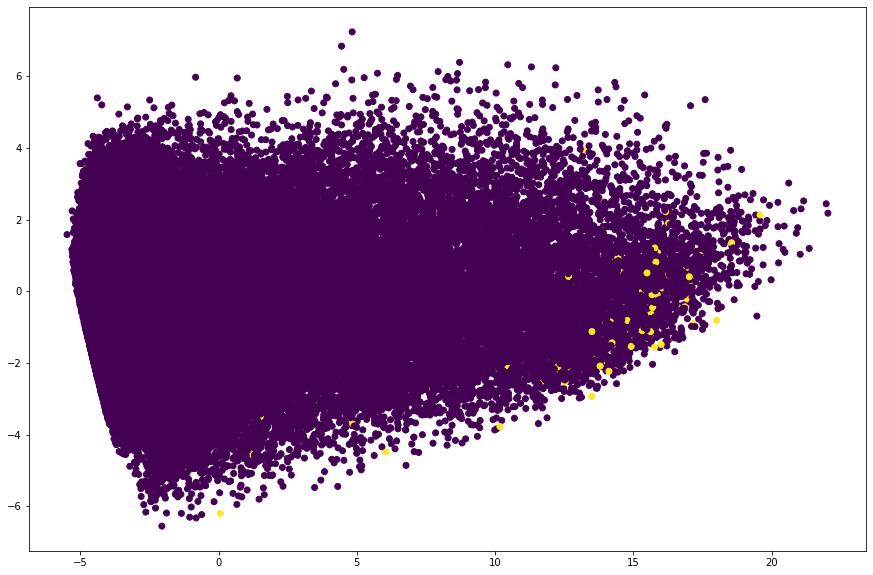

In [33]:
plt.figure(figsize=(15,10))
plt.scatter(compressed[:, 0], compressed[:, 1], c=zy_concat, cmap='viridis') # , s=zy_concat*100+10)

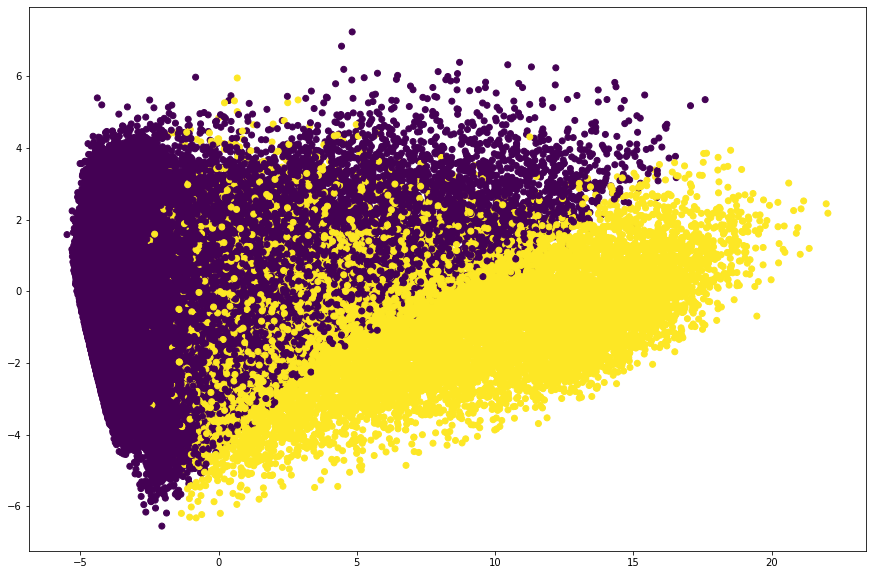

In [32]:
plt.figure(figsize=(15,10))
plt.scatter(compressed[:, 0], compressed[:, 1], c=z_argmax, cmap='viridis')

In [34]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(z_concat)

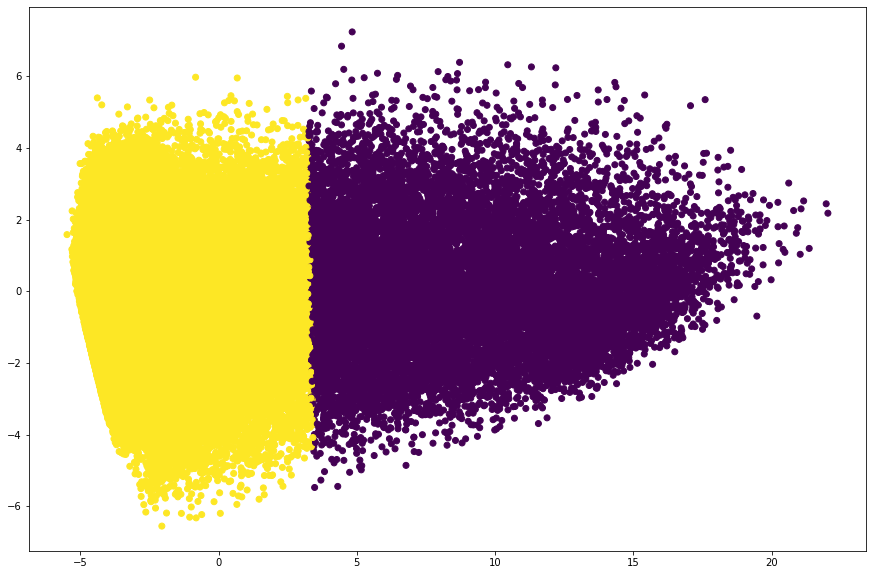

In [35]:
plt.figure(figsize=(15,10))
plt.scatter(compressed[:, 0], compressed[:, 1], c=kmeans.labels_, cmap='viridis')

In [36]:
np.mean(kmeans.labels_ == zy_concat)

0.20493863669968948